<a href="https://colab.research.google.com/github/RealThanosP/pred-main-mod/blob/main/Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial Based notebook on:
---
[Machine Learning for Everybody – Full Course on Youtube](https://www.youtube.com/watch?v=i_LwzRVP7bg&t=627s)

# Clone repository from GitHub

In [ ]:
# Load the data on the server session
!git clone https://github.com/RealThanosP/pred-main-mod

# Change your working directory inside the repository
%cd pred-main-mod

Cloning into 'pred-main-mod'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 41 (delta 3), reused 3 (delta 0), pack-reused 28 (from 2)
Receiving objects: 100% (41/41), 85.19 MiB | 12.21 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (23/23), done.
/content/pred-main-mod/pred-main-mod


# Dataset:
Helwig, N., Pignanelli, E., & Schtze, A. (2015). Condition monitoring of hydraulic systems [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5CW21.


# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import os

# Getting the sensor files in a list (for python remembering)



In [ ]:
folder_path = "data/condition+monitoring+of+hydraulic+systems"

# Define the list of sensors and their corresponding column names
sensors = [
    "PS1", "PS2", "PS3", "PS4", "PS5", "PS6",  # Pressure sensors
    "EPS1",  # Motor power
    "FS1", "FS2",  # Volume flow
    "TS1", "TS2", "TS3", "TS4",  # Temperature sensors
    "VS1",  # Vibration
    "CE",  # Cooling efficiency
    "CP",  # Cooling power
    "SE"  # Efficiency factor
]

# Initialize a list to hold the data from each txt file
all_data = []

In [ ]:
# Gets all the text files from dataset
txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

# Keeps only the data that have a sensor name in the filename
sensor_file_path_list = [f"{folder_path}/{f}" for f in txt_files if any(sensor in f for sensor in sensors)]
sensor_file_path_list.sort()

# Filter sensor files into different lists (for python remembering)
Lists contain the file path of the sensor, so you can **.read_csv()** directly from the list item.

In [ ]:
# Multiple sensors
pressure_sensors = [f for f in sensor_file_path_list if "PS" in f and "EPS" not in f]
temp_sensors = [f for f in sensor_file_path_list if "TS" in f]
flow_sensors = [f for f in sensor_file_path_list if "FS" in f]

# Unary sensors, 1 sensor
vibration_sensor = [f for f in sensor_file_path_list if "VS" in f][0]
cooling_efficiency_sensor = [f for f in sensor_file_path_list if "CE" in f][0]
cooling_power_sensor = [f for f in sensor_file_path_list if "CP" in f][0]
efficiency_factor_sensor = [f for f in sensor_file_path_list if "SE" in f][0]

# Load profile data (The dataset we care about for predictive maintenance)

---
Based on the **description** the classification for the data is:

The target condition values are cycle-wise annotated in �profile.txt� (tab-delimited). As before, the row number represents the cycle number. The columns are

1: Cooler condition / %:
	3: close to total failure
	20: reduced effifiency
	100: full efficiency

2: Valve condition / %:
	100: optimal switching behavior
	90: small lag
	80: severe lag
	73: close to total failure

3: Internal pump leakage:
	0: no leakage
	1: weak leakage
	2: severe leakage

4: Hydraulic accumulator / bar:
	130: optimal pressure
	115: slightly reduced pressure
	100: severely reduced pressure
	90: close to total failure

5: stable flag:
	0: conditions were stable
	1: static conditions might not have been reached yet



In [ ]:
df = pd.read_csv("data/condition+monitoring+of+hydraulic+systems/profile.txt", sep="\t", header=None)
df.columns = ["Cooler condition %", "Valve condition %", "Internal pump leakage", "Hydraulic accumulator / bar", "stable flag"]
df.insert(0, "Cycle", [i + 1 for i in range(len(df))]) # Insert Cycle column for easier plotting
df

,Cycle,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar,stable flag
0,1,3,100,0,130,1
1,2,3,100,0,130,1
2,3,3,100,0,130,1
3,4,3,100,0,130,1
4,5,3,100,0,130,1
...,...,...,...,...,...,...
2200,2201,100,100,0,90,0
2201,2202,100,100,0,90,0
2202,2203,100,100,0,90,0
2203,2204,100,100,0,90,0


# Plot the data

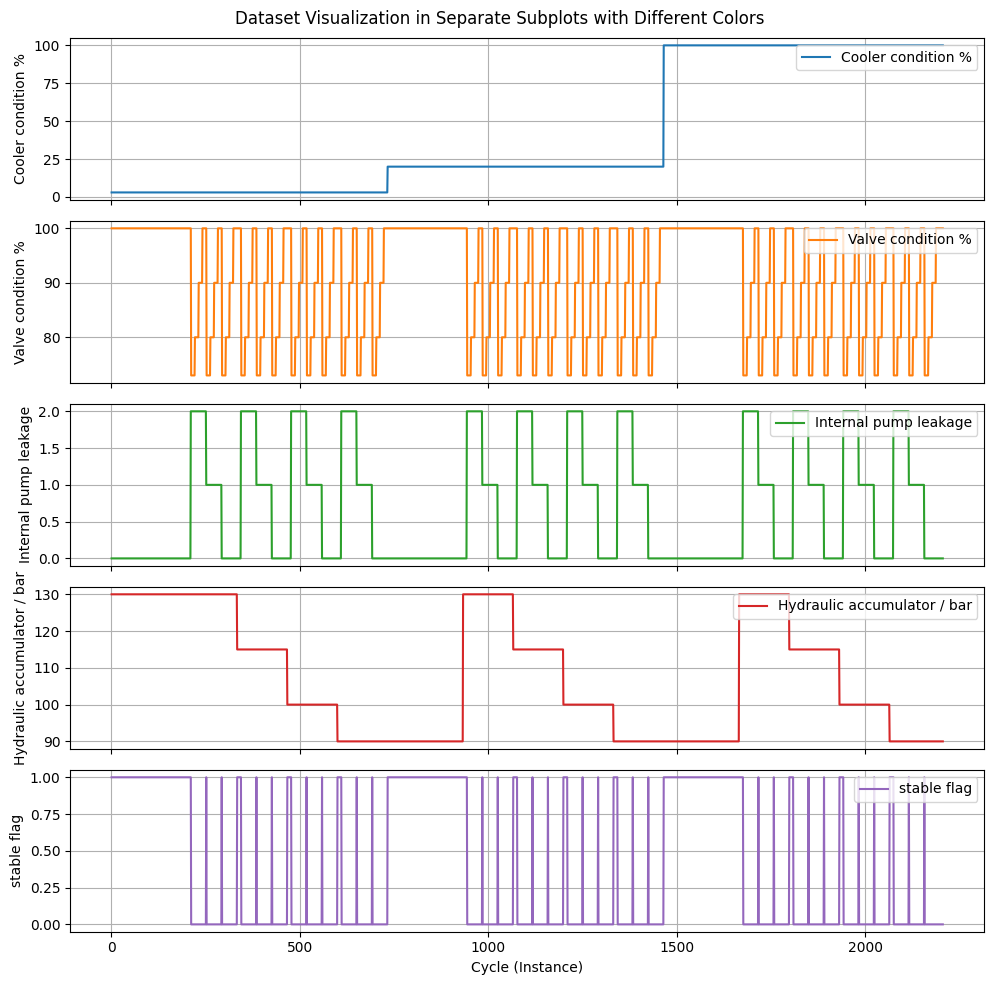

In [ ]:
# Define colors for each subplot
colors = sns.color_palette("tab10", len(df.columns) - 1)  # Use seaborn's color palette

# Create subplots
fig, axes = plt.subplots(nrows=len(df.columns)-1, ncols=1, figsize=(10, 10), sharex=True)

# Plot each column in a separate subplot with a unique color
for i, (col, color) in enumerate(zip(df.columns[1:], colors)):  # Exclude "Cycle"
    axes[i].plot(df["Cycle"], df[col], label=col, color=color, linewidth=1.5)
    axes[i].set_ylabel(col)
    axes[i].legend(loc="upper right")
    axes[i].grid(True)

# Set common X-axis label
axes[-1].set_xlabel("Cycle (Instance)")
fig.suptitle("Dataset Visualization in Separate Subplots with Different Colors")

plt.tight_layout()
plt.show()

# Plot correlation to the state flag

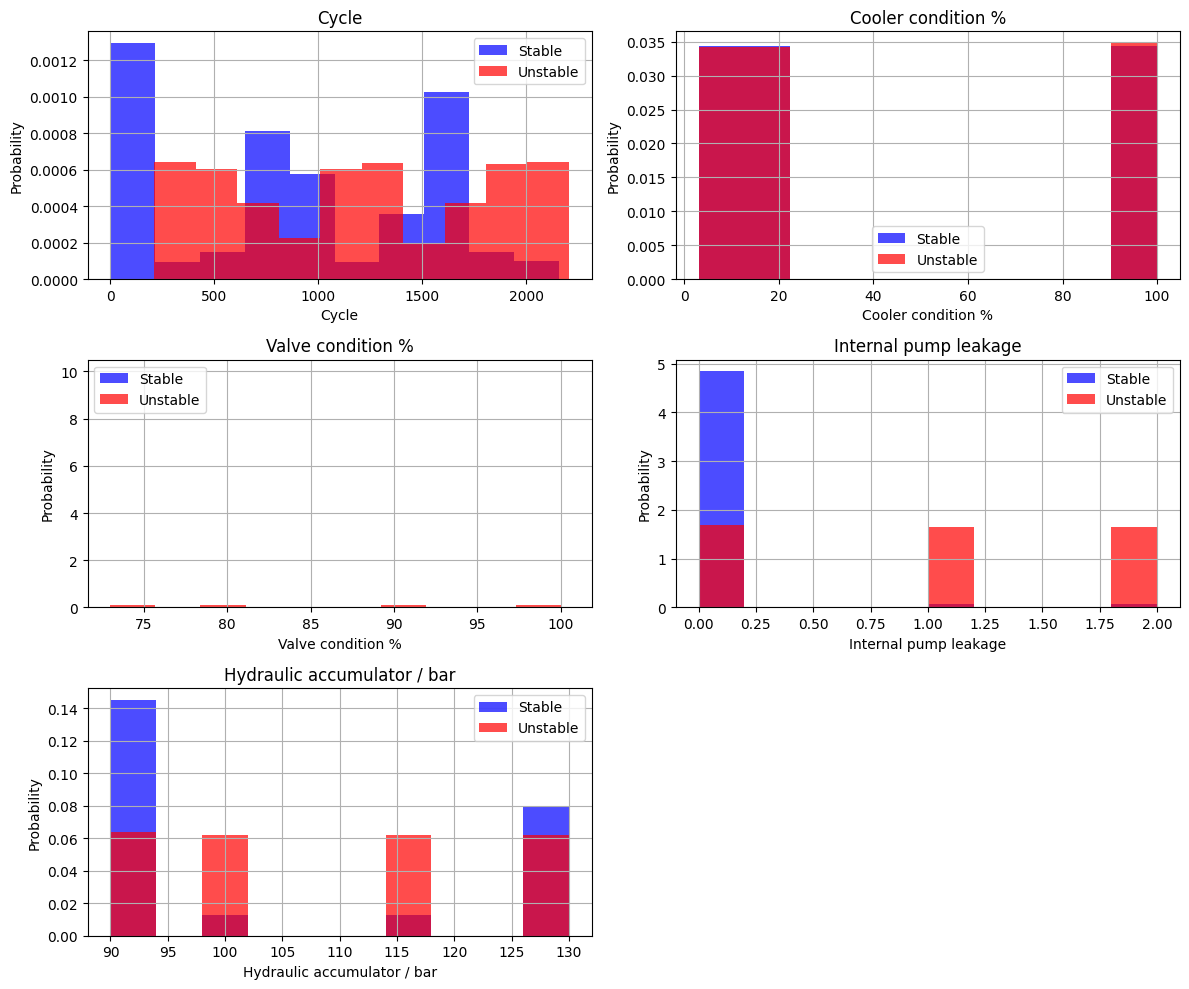

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to easily iterate

# Define colors for histograms
colors = ["blue", "red"]

# Loop through the first 5 columns (excluding "Stable Flag")
for i, label in enumerate(df.columns[:-1]):
    ax = axes[i]

    # Plot histograms for stable and unstable conditions
    ax.hist(df[df['stable flag'] == 1][label], color=colors[0], density=True, alpha=0.7, label="Stable")
    ax.hist(df[df["stable flag"] == 0][label], color=colors[1], density=True, alpha=0.7, label="Unstable")

    ax.set_title(label)
    ax.set_ylabel("Probability")
    ax.set_xlabel(label)
    ax.legend()
    ax.grid(True)

# Hide any extra subplots (if they exist)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Train, validation, test datasets

In [ ]:
train, valid, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))]) # 80-10-10 % split

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# Scale dataset
---
Usually we want to scale our data x-feature vectors and y-target vectorts to a range of (-1, 1) so any data we have at a different scale can be normalized for better accuracy rates

**EX.** x_max = 200 and y_max = 0.3 (156, 0.1) --> (0.78, 0.33).

In [ ]:
def scale_dataset(df:pd.DataFrame, oversample=False):
  x = df[df.columns[:-1]].values # features matrix
  y = df[df.columns[-1]].values # target vector we are tryiing to predict

  scaler = StandardScaler()
  x = scaler.fit_transform(x)

  if oversample:
    ros = RandomOverSampler()
    x, y = ros.fit_resample(x, y)

  data = np.hstack((x, np.reshape(y, (-1, 1))))

  return data, x, y

In [ ]:
train, x_train, y_train = scale_dataset(train, oversample=True)
valid, x_valid, y_valid = scale_dataset(valid, oversample=False)
test, x_test, y_test = scale_dataset(test, oversample=False)

# kNN implementation (k-nearest neighbor)
---
For every feature ***vector*** (which corresponds in a point space) in our dataset we find the k-nearest points *(usually k = 3 or 5)*. So for every prediction the model can be confident that the prediction for this point will be the same **(or close)** to the k nearest neighbors.

### Example:

If lets say that at an instance in time a machine has failures only in cooling and pressure.

We find out that **k=3** neighboring measurements, with the same failures in cooling and pressure have a split of (2 unstable, 1 stable).

So it is probable that the model should consider that the machine is unstable at this instance.

---
This whole algorithm is implemented by sklearn's KNeiboursClassifier object.

We choose Classifier and not Regressor because we want the stable value to be either 0 or 1, not a float.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(x_train, y_train)

y_pred = knn_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       149
           1       0.90      0.97      0.93        72

    accuracy                           0.95       221
   macro avg       0.94      0.96      0.95       221
weighted avg       0.96      0.95      0.96       221



The knn model is **VERY** good for it's simplicity and can be used to make accurate predictions, on this dataset.

# Naive Bayes Implementation
---
A model based on Bayes Rule (from probability)

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

y_pred = nb_model.predict(x_test)
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.67      1.00      0.81       149
           1       1.00      0.00      0.00        72

    accuracy                           0.67       221
   macro avg       0.84      0.50      0.40       221
weighted avg       0.78      0.67      0.54       221



Naive Bayes model has **TERRIBLE** recall (at least compared to kNN)  and should not be used in this dataset.

# Logistic Regression